In [ ]:
!pip3 install torch
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import sys
import yaml
from torchvision import transforms, datasets
import torchvision
import numpy as np
import os
from sklearn import preprocessing
from torch.utils.data.dataloader import DataLoader
import tensorflow as tf

#구글 드라이브에 있는 폴더 import 할 수 있도록 권한 부여
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/yeonju_byol/PyTorch-BYOL')
from models.resnet_base_network import ResNet18
# ResNet18 네트워크 import

In [ ]:
batch_size = 512 
# dataloader 코드에서 사용됨

data_transforms = torchvision.transforms.Compose([transforms.ToTensor()]) 
# 데이터를 tensor로 바꾸는 과정

In [ ]:
config = yaml.load(open("/content/drive/MyDrive/Colab Notebooks/yeonju_byol/PyTorch-BYOL/config/config.yaml", "r"), Loader=yaml.FullLoader)
# config파일 로드
# yaml.load() 함수로 YAML 파일을 파싱하여 config 라는 이름의 Python 객체로 저장

print(config)

{'network': {'name': 'resnet18', 'fine_tune_from': 'resnet-18_40-epochs', 'projection_head': {'mlp_hidden_size': 512, 'projection_size': 128}}, 'data_transforms': {'s': 1, 'input_shape': '(96,96,3)'}, 'trainer': {'batch_size': 256, 'm': 0.996, 'checkpoint_interval': 5000, 'max_epochs': 400, 'num_workers': 4}, 'optimizer': {'params': {'lr': 0.03, 'momentum': 0.9, 'weight_decay': 0.0004}}}


In [ ]:
train_dataset = datasets.STL10('/content/drive/MyDrive/Colab Notebooks/yeonju_byol/Downloads/', split='train', download=True,
                               transform=data_transforms)

test_dataset = datasets.STL10('/content/drive/MyDrive/Colab Notebooks/yeonju_byol/Downloads/', split='test', download=True,
                               transform=data_transforms) 

# 최초 다운로드 시에만 downlad=True로 변경
# datasets 정의
# split에 쓴 것에 따라 데이터 세트가 결정됨
# transform은 PIL 이미지를 가져와 변환된 버전을 반환해줌

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print("Input shape:", train_dataset[0][0].shape)
# train_dataset의 shape은 크게 3개의 배열로 묶여있고 그 안은 96*96 배열의 모습을 취함.
# 즉, 96*96 3차원 이미지 파일 -> color니까

Input shape: torch.Size([3, 96, 96])


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          num_workers=0, drop_last=False, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size,
                          num_workers=0, drop_last=False, shuffle=True)

# loader에 데이터셋을 불러오는 과정
# train_dataset/test_dataset : dataset은 각 train과 test dataset
# batch_size: 1회 당 batch_size개의 데이터씩 분할
# num_workers : default 값은 0이고, data 로딩을 위해 몇 개의 서브 프로세스를 사용할 것인지를 결정하는 파라미터
# drop_last : batch의 길이가 다른 경우에 따라 loss를 구하기 귀찮은 경우가 생기고, batch의 크기에 따른 의존도 높은 함수를 사용할 때 걱정이 되는 경우 마지막 batch를 사용하지 않을 수 있게 하는 파라미터
# shuffle : 데이터들의 순서는 섞어서 분할

In [ ]:
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
encoder = ResNet18(**config['network'])
# byol 인코더 네트워크 설정
# 불러올 모델 설정

output_feature_dim = encoder.projetion.net[0].in_features
# =512
# resnet18의 마지막 노드 개수? 

cpu


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
#load pre-trained parameters
load_params = torch.load(os.path.join('/content/drive/MyDrive/Colab Notebooks/yeonju_byol/PyTorch-BYOL/runs/b 256, e 400 _ 2/checkpoints/model.pth'),
                         map_location=torch.device(torch.device(device)))
# runs폴더에서 불러올 Training된 model설정
# pickle을 사용하여 저장된 객체 파일들을 역직렬화하여 메모리에 올리는 과정.

# state_dict 는 간단히 말해 각 계층을 매개변수 텐서로 매핑되는 Python 사전(dict) 객체입니다.
if 'online_network_state_dict' in load_params:
    encoder.load_state_dict(load_params['online_network_state_dict'])
    print("Parameters successfully loaded.")
    # 역직렬화된 state_dict 를 사용하여 모델의 매개변수(ex.가중치와 편향)들을 불러오는 과정
    # path 파일에 있는 online_network 사전객체 매개변수들을 load.state_dict로 불러오는 것

# remove the projection head
encoder = torch.nn.Sequential(*list(encoder.children())[:-1])    
# Sequential 객체는 그 안에 포함된 각 모듈을 순차적으로 실행함.   
# [:-1] # 맨 마지막 값을 제외하고 모두
# encoder에서 MLPHead 제거

encoder = encoder.to(device)
# 모델에서 사용하는 input Tensor들은 input = input.to(device) 을 호출해야 합니다.
# GPU에서 학습한 모델을 GPU에서 불러올 때에는, 초기화된 model 에 model.to(torch.device('cuda')) 을 호출하여 CUDA 최적화된 모델로 변환해야함
# 또한 모델에 데이터를 제공하는 모든 입력에 .to(torch.device('cuda')) 함수를 호출해야 함

Parameters successfully loaded.


In [ ]:
encoder

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

(encoder): Sequential(

    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
	# 입력 이미지의 채널 수 : 3
	# 컨볼루션에 의해 생성된 채널 수 : 64
	# 컨볼루션 커널의 크기 : (7 , 7)
	# 컨볼루션의 스트라이드 : (2 , 2)
	# input의 모든 4면에 추가된 패딩 : (3 , 3)
	# output에 학습 가능한 편향을 추가하지 않음

    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
	# (N, C, H, W) 크기의 기대 input의 채널의 수 : 64
	# 수치적 안정성을 위해 분모에 추가된 값 : 기본 값
	# running_mean 및 running_var 계산에 사용되는 값 : 기본 값
	# 이 모듈은 학습 가능한 affine 매개변수를 갖음
	# 이 모듈이 실행 평균과 분산을 추적함

    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
	# 최대를 넘길 수 있는 창의 크기 : 3
	# 보폭 of the window : 2
	# 양쪽에 추가할 암시적 제로 패딩 : 1
	# 창에서 요소의 보폭을 제어하는 매개변수 : 1
	# 
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )

      .
      .
      .
    (8): AdaptiveAvgPool2d(output_size=(1, 1))

In [ ]:
# 로지스틱 회귀 클래스
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        # nn.Linear 를 선형 레이어로 사용
        # 들어오는 데이터에 대해 선형 변환을 적용: y = xA^T + b
        # torch.nn.Linear(각 입력 샘플의 크기, 각 출력 샘플의 크기)
        
    def forward(self, x):
        return self.linear(x)

In [ ]:
logreg = LogisticRegression(output_feature_dim, 10) # (512,10)
logreg = logreg.to(device)

In [ ]:
def get_features_from_encoder(encoder, loader):
    
    x_train = []
    y_train = []

    # get the features from the pre-trained model
    # i는 인덱스, (x,y)는 원소
    for i, (x, y) in enumerate(loader):
        with torch.no_grad():
            feature_vector = encoder(x)
            x_train.extend(feature_vector) # feature_vector의 각 항목들을 x_train에 각각의 원소로 넣음.
            y_train.extend(y.numpy()) # y를 넘파이 배열로 변환하여 y_train에 각각의 원소로 넣음.

        # torch.no_grad : 그래디언트 계산을 비활성화하는 컨텍스트 관리자.

            
    x_train = torch.stack(x_train) # 새 차원을 따라 텐서 시퀀스를 연결. 연결할 때 마다 차원 추가됨.
    y_train = torch.tensor(y_train) # y_train 데이터를 복사해 autograd 히스토리가 없는 텐서를 구성.
    return x_train, y_train

In [ ]:
encoder.eval() # evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
x_train, y_train = get_features_from_encoder(encoder, train_loader)
x_test, y_test = get_features_from_encoder(encoder, test_loader)

if len(x_train.shape) > 2:
    x_train = torch.mean(x_train, dim=[2, 3]) # 차원 축소
    x_test = torch.mean(x_test, dim=[2, 3]) # 차원 축소
    
print("Training data shape:", x_train.shape, y_train.shape)
print("Testing data shape:", x_test.shape, y_test.shape)

Training data shape: torch.Size([5000, 512]) torch.Size([5000])
Testing data shape: torch.Size([8000, 512]) torch.Size([8000])


In [ ]:
def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test):

    train = torch.utils.data.TensorDataset(X_train, y_train) # Dataset wrapping tensors
    train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test, batch_size=512, shuffle=False)
    return train_loader, test_loader

In [ ]:
# 데이터 전처리
scaler = preprocessing.StandardScaler() # 평균을 제거하고 단위 분산에 맞게 조정하여 features를 표준화
scaler.fit(x_train) # x_train 데이터를 학습시키는 메서드
x_train = scaler.transform(x_train).astype(np.float32) # 학습시킨 것을 x_train에 적용하는 메서드
x_test = scaler.transform(x_test).astype(np.float32)

In [ ]:
train_loader, test_loader = create_data_loaders_from_arrays(torch.from_numpy(x_train), y_train, torch.from_numpy(x_test), y_test)

In [ ]:
optimizer = torch.optim.Adam(logreg.parameters(), lr=3e-4) # adamoptimizer 최적화
criterion = torch.nn.CrossEntropyLoss() # 기준 : CrossEntropyLoss (= 입력과 목표 사이의 교차 엔트로피 손실을 계산)
eval_every_n_epochs = 10

for epoch in range(200):
#     train_acc = []
    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)

        # 최적화 과정 (~ optimizer.step())
        # zero the parameter gradients
        # 모델 매개변수의 변화도를 재설정. 
        # 기본적으로 변화도는 더해지기(add up) 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 0으로 설정.
        optimizer.zero_grad()        
        
        logits = logreg(x)
        predictions = torch.argmax(logits, dim=1)
        # dimension (열)을 기준으로 input tensor 안에 있는 최대값의 위치를 각각 반환

        # 손실(loss) 계산
        loss = criterion(logits, y)
        
        loss.backward() # 예측 손실(prediction loss)을 역전파
        optimizer.step() # 역전파 단계에서 수집된 변화도로 매개변수를 조정
    
    total = 0
    if epoch % eval_every_n_epochs == 0:
        correct = 0
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            logits = logreg(x)
            predictions = torch.argmax(logits, dim=1)
            
            total += y.size(0)
            correct += (predictions == y).sum().item()
            
        acc = 100 * correct / total
        print(f"Testing accuracy: {np.mean(acc)}")

Testing accuracy: 74.175
Testing accuracy: 82.5
Testing accuracy: 83.3875
Testing accuracy: 83.625
Testing accuracy: 83.575
Testing accuracy: 83.3
Testing accuracy: 83.175
Testing accuracy: 82.9875
Testing accuracy: 82.7625
Testing accuracy: 82.6375
Testing accuracy: 82.55
Testing accuracy: 82.425
Testing accuracy: 82.35
Testing accuracy: 82.25
Testing accuracy: 82.2125
Testing accuracy: 82.2
Testing accuracy: 82.0875
Testing accuracy: 81.9375
Testing accuracy: 81.9
Testing accuracy: 81.625


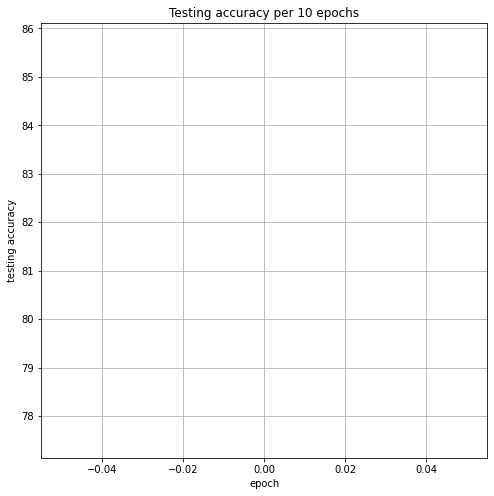

In [ ]:
#그래프를 그리기 위한 설정
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

plt.rcParams['figure.figsize'] = (8,8) #캔버스 가로 세로 길이 설정
plt.title('Testing accuracy per 10 epochs')
plt.xlabel('epoch')
plt.ylabel('testing accuracy')
#plt.legend(['test Accuracy',], loc='upper right')
plt.grid()

plt.plot(np.mean(acc))
plt.show()
